In [3]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [1]:
%pip install seaborn
%pip install simpy
%pip install plotly
%pip install plotnine

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Initialize Sparks Contest

In [2]:
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import pandas as pd

import simpy

from plotnine import *
import plotly.graph_objects as go
import numpy as np

In [3]:
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession 
from pyspark.conf import SparkConf
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import StringType, IntegerType, StructType, StructField

In [91]:
spark.stop()

In [4]:
spark = SparkSession \
    .builder \
    .appName("regression") \
    .master("local[4]") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.network.timeout","3600")\
    .config("spark.executor.heartbeatInterval","3000s")\
    .getOrCreate()

# Read Dataset

In [5]:
spark

In [6]:
df = spark.read.json('../data/cleaned_dataset')
df.show(3,truncate=False,vertical =True)
df.count()

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------
 acousticness          | 0.658                                                                                                                              
 age                   | 41.821917808219176                                                                                                                 
 avg_artist_followers  | 5403.5                                                                                                                             
 avg_artist_popularity | 40.0                                                                                                                               
 danceability          | 0.602                                                                                                                              
 duration_ms           | 156067                           

583363

In [7]:
df.printSchema()

root
 |-- acousticness: double (nullable = true)
 |-- age: double (nullable = true)
 |-- avg_artist_followers: double (nullable = true)
 |-- avg_artist_popularity: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- energy: double (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id_track: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: long (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- popularity_track: long (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- sum_artist_followers: long (nullable = true)
 |-- sum_artist_popularity: long (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: long (nullable = true)
 |-- valence: double (nullable = true)



# Data Preparation 

In [8]:

df = df.na.drop(how='any')
df.count()

583363

In [9]:
df.columns

['acousticness',
 'age',
 'avg_artist_followers',
 'avg_artist_popularity',
 'danceability',
 'duration_ms',
 'energy',
 'genres',
 'id_track',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity_track',
 'release_date',
 'speechiness',
 'sum_artist_followers',
 'sum_artist_popularity',
 'tempo',
 'time_signature',
 'valence']

In [10]:
all_numerical_columns = ['acousticness', 'age', 'avg_artist_followers', 'avg_artist_popularity', 'danceability', 'duration_ms',
    'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity_track', 'speechiness',
    'sum_artist_followers', 'sum_artist_popularity', 'tempo', 'time_signature', 'valence']

technical_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',  'speechiness', 'tempo', 'time_signature', 'valence','popularity_track']

In [12]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=technical_columns,
    outputCol="features")

df = assembler.transform(df)
df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[0.658,0.602,1560...|
|[0.543,0.77,22013...|
|[4.8E-5,0.212,250...|
|[0.144,0.362,4570...|
|[0.957,0.343,2828...|
|[0.119,0.893,2170...|
|[0.96,0.351,54510...|
|[0.168,0.422,2569...|
|[0.775,0.627,2491...|
|[0.971,0.554,1898...|
|[0.945,0.189,1817...|
|[0.0904,0.46,2030...|
|[0.868,0.764,2132...|
|[0.81,0.413,28202...|
|[0.69,0.829,16121...|
|[0.0451,0.632,237...|
|[0.501,0.442,2442...|
|[0.0424,0.582,207...|
|[0.136,0.881,2006...|
|[0.44,0.686,17826...|
+--------------------+
only showing top 20 rows



<AxesSubplot:>

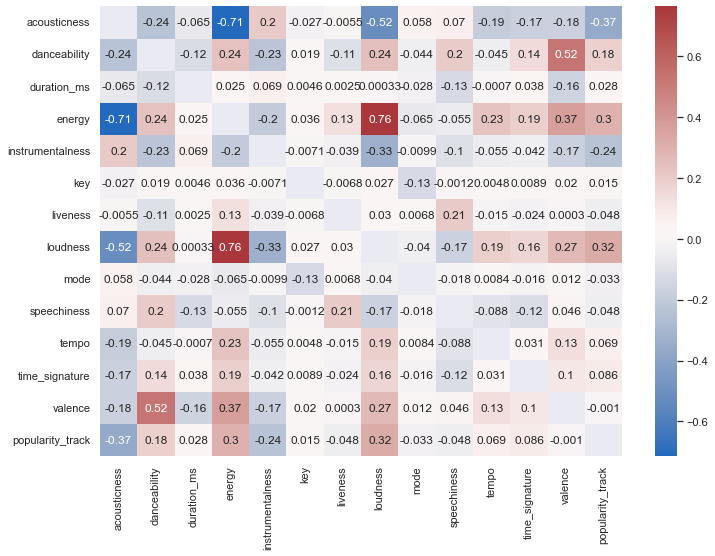

In [39]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
corrMat = Correlation.corr(df, "features").head()[0]

corr = pd.DataFrame(corrMat.toArray(),index=technical_columns,columns=technical_columns)
for i in corr: corr.loc[i,i] = np.nan
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr,cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=technical_columns, yticklabels=technical_columns,annot=True)

<AxesSubplot:>

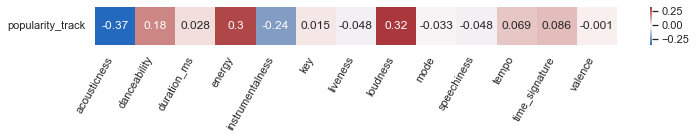

In [56]:
technical_columns.remove('popularity_track')
sns.set(rc={'figure.figsize':(11.7,0.7)})
heatmap = sns.heatmap(corr.loc[['popularity_track'],technical_columns],cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=technical_columns, yticklabels=['popularity'],annot=True)
heatmap.set_xticklabels(technical_columns, rotation=60,horizontalalignment='right')
heatmap.set_yticklabels(['popularity_track'], rotation=0) 
heatmap

In [ ]:
df = df.drop("features")

In [58]:

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=all_numerical_columns,
    outputCol="features")

df = assembler.transform(df)
df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[0.658,41.8219178...|
|[0.543,45.8246575...|
|[4.8E-5,25.673972...|
|[0.144,31.8136986...|
|[0.957,4.07123287...|
|[0.119,13.8027397...|
|[0.96,71.84109589...|
|[0.168,6.66575342...|
|[0.775,30.6246575...|
|[0.971,20.8054794...|
|[0.945,61.8356164...|
|[0.0904,38.468493...|
|[0.868,16.0191780...|
|[0.81,30.81369863...|
|[0.69,25.60821917...|
|[0.0451,33.010958...|
|[0.501,5.98904109...|
|[0.0424,5.2410958...|
|[0.136,0.50410958...|
|[0.44,2.575342465...|
+--------------------+
only showing top 20 rows



<AxesSubplot:>

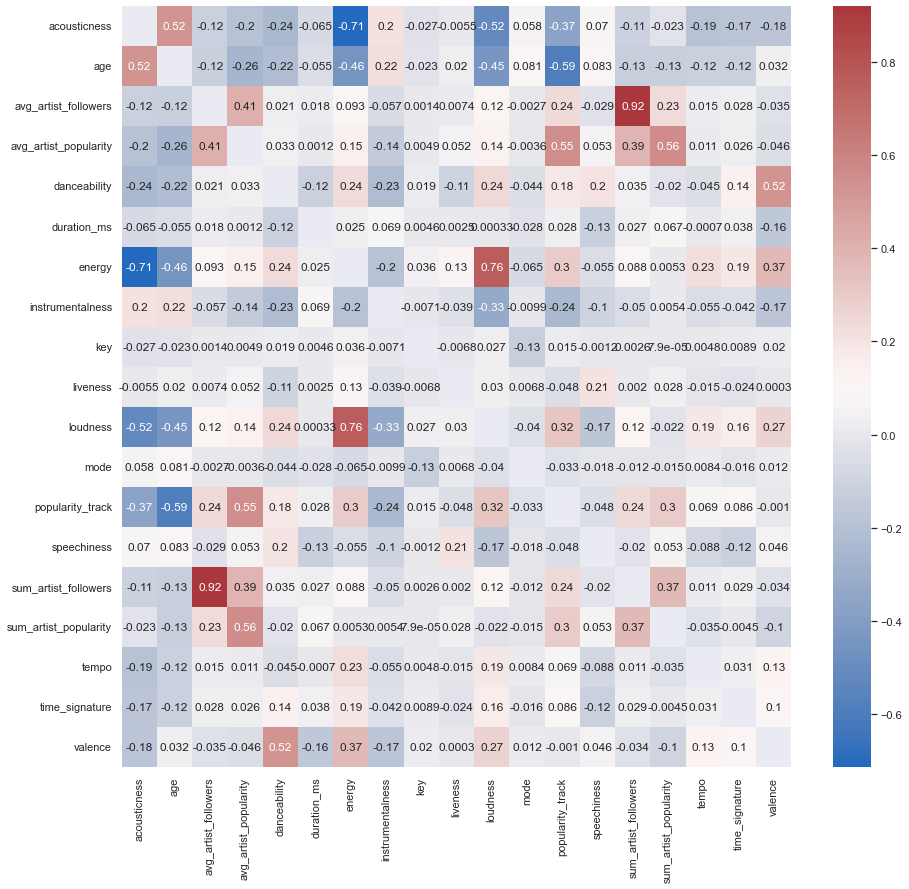

In [60]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
corrMat = Correlation.corr(df, "features").head()[0]

corr = pd.DataFrame(corrMat.toArray(),index=all_numerical_columns,columns=all_numerical_columns)
for i in corr: corr.loc[i,i] = np.nan
sns.set(rc={'figure.figsize':(15,14)})
sns.heatmap(corr,cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=all_numerical_columns, yticklabels=all_numerical_columns,annot=True)

In [ ]:
all_numerical_columns.remove('popularity_track')

<AxesSubplot:>

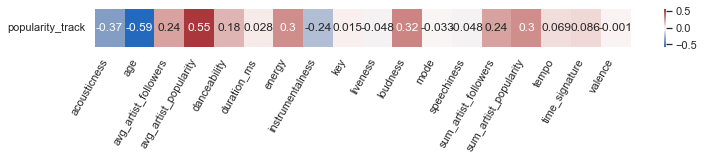

In [62]:

sns.set(rc={'figure.figsize':(12,0.7)})
heatmap = sns.heatmap(corr.loc[['popularity_track'],all_numerical_columns],cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=all_numerical_columns, yticklabels=['popularity'],annot=True)
heatmap.set_xticklabels(all_numerical_columns, rotation=60,horizontalalignment='right')
heatmap.set_yticklabels(['popularity_track'], rotation=0) 
heatmap

In [57]:
%pip install pyspark_dist_explore

  Using cached pyspark_dist_explore-0.1.8-py3-none-any.whl (7.2 kB)
Note: you may need to restart the kernel to use updated packages.



sns.heatmap(corr,cmap=sns.color_palette("vlag", as_cmap=True),xticklabels=technical_columns, yticklabels=technical_columns)

In [64]:
import pyspark.sql.functions as F

def value_counts(spark_df, colm, order=1, n=10):

    if order==1 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc_nulls_first("count")).head(n),columns=["value","count"]) 
    if order==2 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.asc(colm)).head(n),columns=["value","count"]) 
    if order==3 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc(colm)).head(n),columns=["value","count"]) 
    if order==4 :
        return pd.concat([pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.asc(colm)).head(n),columns=["value","count"]),
                          pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc(colm)).head(n),columns=["value","count"])])

In [67]:
count = value_counts(df, 'popularity_track', order=2, n=100)
count

,value,count
0,0,43901
1,1,11734
2,2,9415
3,3,7995
4,4,7607
...,...,...
95,95,1
96,96,2
97,97,2
98,98,1


Text(0, 0.5, 'Popularity')

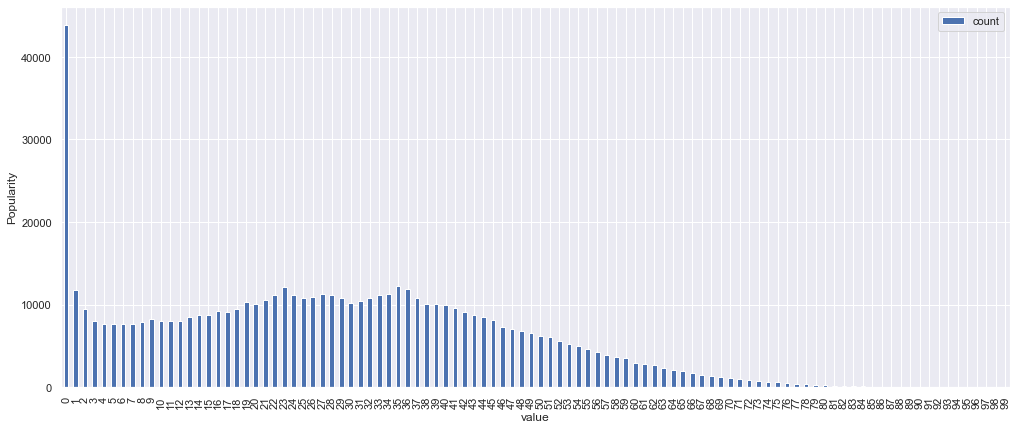

In [79]:
sns.set(rc={'figure.figsize':(17,7)})
count.plot.bar('value','count')
plt.ylabel('Count')
plt.ylabel('Popularity')

In [57]:
numerical_columns = ['duration_ms','danceability','energy','key','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=numerical_columns,
    outputCol="features")

df = assembler.transform(df)
df.select(df.features).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[126903.0,0.6449999809265137,0.4449999928474426,0.0,-13.338000297546387,0.45100000500679016,0.6740000247955322,0.7440000176429749,0.1509999930858612,0.12700000405311584,104.85099792480469,3.0]    |
|[98200.0,0.6949999928474426,0.2630000114440918,0.0,-22.13599967956543,0.9570000171661377,0.796999990940094,0.0,0.14800000190734863,0.6549999713897705,102.00900268554688,1.0]                       |
|[181

# Linear Regression

In [58]:
train, test = df.randomSplit([0.7, 0.3])

In [19]:
from pyspark.ml.linalg import Vectors
from pyspark.mllib.tree import RandomForest

DataFrame[id: string, name: string, popularity: float, duration_ms: float, explicit: string, artists: string, id_artists: string, release_date: string, danceability: float, energy: float, key: float, loudness: float, mode: string, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: float, features: vector]

In [20]:
from pyspark.ml.regression import LinearRegression

# Load training data
training = df

lr = LinearRegression(labelCol='popularity', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [0.9837021109117604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 0.450576028923295
numIterations: 10
objectiveHistory: [0.5000000000000002, 0.3917857015706897, 0.0569052477024183, 0.02350881837373394, 0.015060903882700753, 0.014583558859491811, 0.01458236832637065, 0.01458235006375166, 0.014582349111096815, 0.014582349061402471, 0.014582349058810107]
+-------------------+
|          residuals|
+-------------------+
|-0.3527886943938574|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
|-0.4342781398350555|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
| -0.450576028923295|
+-------------------+
only showing top 20 rows

RMSE: 0.299032
r2: 0.999734


In [48]:
model.numFeatures

13

In [36]:
help(trainingSummary)

Help on LinearRegressionTrainingSummary in module pyspark.ml.regression object:

class LinearRegressionTrainingSummary(LinearRegressionSummary)
 |  LinearRegressionTrainingSummary(java_obj=None)
 |  
 |  Linear regression training results. Currently, the training summary ignores the
 |  training weights except for the objective trace.
 |  
 |  .. versionadded:: 2.0.0
 |  
 |  Method resolution order:
 |      LinearRegressionTrainingSummary
 |      LinearRegressionSummary
 |      pyspark.ml.wrapper.JavaWrapper
 |      builtins.object
 |  
 |  Readonly properties defined here:
 |  
 |  objectiveHistory
 |      Objective function (scaled loss + regularization) at each
 |      iteration.
 |      This value is only available when using the "l-bfgs" solver.
 |      
 |      .. versionadded:: 2.0.0
 |      
 |      See Also
 |      --------
 |      LinearRegression.solver
 |  
 |  totalIterations
 |      Number of training iterations until termination.
 |      This value is only available whe

# Random Forest Regressor

In [24]:
# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Note: Use larger numTrees in practice.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
model = RandomForest.trainRegressor(df, categoricalFeaturesInfo={},
                                    numTrees=3, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=4, maxBins=32)

NameError: name 'trainingData' is not defined

In [59]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator



# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features",labelCol='popularity')



# Train model.  This also runs the indexer.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)


In [60]:

# Select example rows to display.
predictions.select("prediction", "popularity", "features").show(5)

+------------------+----------+--------------------+
|        prediction|popularity|            features|
+------------------+----------+--------------------+
| 37.13412162780104|       0.0|[179747.0,0.78799...|
|20.226543139110614|       8.0|[92867.0,0.159999...|
| 18.56349396164925|      12.0|[364280.0,0.19200...|
| 6.742532296175014|       0.0|[158145.0,0.35400...|
|37.021339360941795|      82.0|[222973.0,0.35199...|
+------------------+----------+--------------------+
only showing top 5 rows



In [54]:
model.explainParams()

"bootstrap: Whether bootstrap samples are used when building trees. (default: True)\ncacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the fe

In [41]:
help(model)

Help on RandomForestRegressionModel in module pyspark.ml.regression object:

class RandomForestRegressionModel(_JavaRegressionModel, pyspark.ml.tree._TreeEnsembleModel, _RandomForestRegressorParams, pyspark.ml.util.JavaMLWritable, pyspark.ml.util.JavaMLReadable)
 |  RandomForestRegressionModel(java_model=None)
 |  
 |  Model fitted by :class:`RandomForestRegressor`.
 |  
 |  .. versionadded:: 1.4.0
 |  
 |  Method resolution order:
 |      RandomForestRegressionModel
 |      _JavaRegressionModel
 |      RegressionModel
 |      pyspark.ml.tree._TreeEnsembleModel
 |      pyspark.ml.wrapper.JavaPredictionModel
 |      pyspark.ml.base.PredictionModel
 |      pyspark.ml.wrapper.JavaModel
 |      pyspark.ml.wrapper.JavaTransformer
 |      pyspark.ml.wrapper.JavaParams
 |      pyspark.ml.wrapper.JavaWrapper
 |      pyspark.ml.base.Model
 |      pyspark.ml.base.Transformer
 |      pyspark.ml.base._PredictorParams
 |      pyspark.ml.param.shared.HasLabelCol
 |      pyspark.ml.param.shared.HasFe

In [61]:


evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 15.8438


In [62]:


evaluator = RegressionEvaluator(
    labelCol="popularity", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)


R sqaure = 0.255637


In [46]:
help(model)

Help on RandomForestRegressionModel in module pyspark.ml.regression object:

class RandomForestRegressionModel(_JavaRegressionModel, pyspark.ml.tree._TreeEnsembleModel, _RandomForestRegressorParams, pyspark.ml.util.JavaMLWritable, pyspark.ml.util.JavaMLReadable)
 |  RandomForestRegressionModel(java_model=None)
 |  
 |  Model fitted by :class:`RandomForestRegressor`.
 |  
 |  .. versionadded:: 1.4.0
 |  
 |  Method resolution order:
 |      RandomForestRegressionModel
 |      _JavaRegressionModel
 |      RegressionModel
 |      pyspark.ml.tree._TreeEnsembleModel
 |      pyspark.ml.wrapper.JavaPredictionModel
 |      pyspark.ml.base.PredictionModel
 |      pyspark.ml.wrapper.JavaModel
 |      pyspark.ml.wrapper.JavaTransformer
 |      pyspark.ml.wrapper.JavaParams
 |      pyspark.ml.wrapper.JavaWrapper
 |      pyspark.ml.base.Model
 |      pyspark.ml.base.Transformer
 |      pyspark.ml.base._PredictorParams
 |      pyspark.ml.param.shared.HasLabelCol
 |      pyspark.ml.param.shared.HasFe

In [48]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1634072596531'),
 ('spark.master', 'local[4]'),
 ('spark.driver.port', '58185'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1634072595416'),
 ('spark.app.name', 'Python Spark SQL basic example'),
 ('spark.sql.warehouse.dir',
  'file:/C:/Users/carlo/Desktop/university/data%20science%20and%20business%20informatics/DDAM/code/spark-warehouse'),
 ('spark.driver.host', 'DESKTOP-FIMTLSS.station'),
 ('spark.driver.maxResultSize', '8g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [28]:
help(spark.conf)

Help on RuntimeConfig in module pyspark.sql.conf object:

class RuntimeConfig(builtins.object)
 |  RuntimeConfig(jconf)
 |  
 |  User-facing configuration API, accessible through `SparkSession.conf`.
 |  
 |  Options set here are automatically propagated to the Hadoop configuration during I/O.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, jconf)
 |      Create a new RuntimeConfig that wraps the underlying JVM object.
 |  
 |  get(self, key, default=<no value>)
 |      Returns the value of Spark runtime configuration property for the given key,
 |      assuming it is set.
 |      
 |      .. versionadded:: 2.0
 |  
 |  isModifiable(self, key)
 |      Indicates whether the configuration property with the given key
 |      is modifiable in the current session.
 |      
 |      .. versionadded:: 2.4
 |  
 |  set(self, key, value)
 |      Sets the given Spark runtime configuration property.
 |      
 |      .. versionadded:: 2.0
 |  
 |  unset(self, key)
 |      Resets the configur

In [ ]:



# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned regression forest model:')
print(model.toDebugString())

# Save and load model
model.save(sc, f'/content/drive/Shareddrives/DDAM/models/rf-regression.csv')
#sameModel = RandomForestModel.load(sc, "target/tmp/myRandomForestRegressionModel")

NameError: ignored